In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"edvinasslavinskas","key":"5e7f0cc4964039377fd1b84d46795b88"}'}

In [ ]:
# Kaggle API key
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Cityscapes dataset (original images and masks)
!kaggle datasets download -d dansbecker/cityscapes-image-pairs
!unzip cityscapes-image-pairs.zip -d dataset/

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# New folders for original images and masks
os.makedirs("dataset_processed/train/images", exist_ok=True)
os.makedirs("dataset_processed/train/masks", exist_ok=True)
os.makedirs("dataset_processed/val/images", exist_ok=True)
os.makedirs("dataset_processed/val/masks", exist_ok=True)

# Function for splitting images (half of the image is original and half of the image are masks)
def split_image(image_path, save_dir_images, save_dir_masks):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    mid = w // 2  # Split in half

    original = image[:, :mid, :]  # left side – original image
    mask = image[:, mid:, :]  # right side - segmentation mask

    filename = os.path.basename(image_path)

    cv2.imwrite(os.path.join(save_dir_images, filename), original)
    cv2.imwrite(os.path.join(save_dir_masks, filename), mask)

# Process all the training images
train_images = sorted(os.listdir("dataset/cityscapes_data/train"))
for img in tqdm(train_images, desc="Processing Train Images"):
    split_image(f"dataset/cityscapes_data/train/{img}", "dataset_processed/train/images", "dataset_processed/train/masks")

# Process all the validation images
val_images = sorted(os.listdir("dataset/cityscapes_data/val"))
for img in tqdm(val_images, desc="Processing Validation Images"):
    split_image(f"dataset/cityscapes_data/val/{img}", "dataset_processed/val/images", "dataset_processed/val/masks")

Processing Validation Images: 100%|██████████| 500/500 [00:01<00:00, 474.01it/s]


In [ ]:
import random
import shutil

# Final folders
final_train_dir = "dataset_final/train"
final_test_dir = "dataset_final/test"

os.makedirs(f"{final_train_dir}/images", exist_ok=True)
os.makedirs(f"{final_train_dir}/masks", exist_ok=True)
os.makedirs(f"{final_test_dir}/images", exist_ok=True)
os.makedirs(f"{final_test_dir}/masks", exist_ok=True)

# Picking up the images and mix
train_images = sorted(os.listdir("dataset_processed/train/images"))
random.shuffle(train_images)

# 400 images for training and 100 images for testing
selected_train_images = train_images[:400]
selected_test_images = train_images[400:500]

# We move the training data to the final folders
for img in selected_train_images:
    shutil.copy(f"dataset_processed/train/images/{img}", f"{final_train_dir}/images/{img}")
    shutil.copy(f"dataset_processed/train/masks/{img}", f"{final_train_dir}/masks/{img}")

# We move the testing data to the final folders
for img in selected_test_images:
    shutil.copy(f"dataset_processed/train/images/{img}", f"{final_test_dir}/images/{img}")
    shutil.copy(f"dataset_processed/train/masks/{img}", f"{final_test_dir}/masks/{img}")

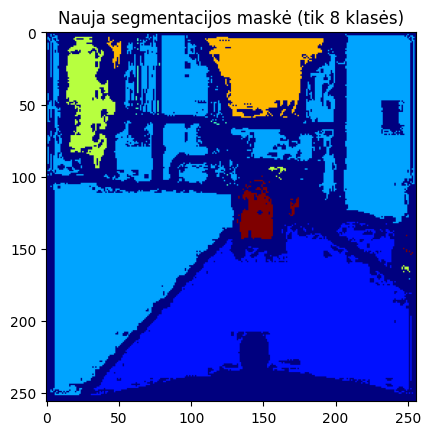

In [ ]:
# Color map with 8 categories (original masks have much more categories)
COLOR_MAP = {
    (  0,  0,  0): 0, # void
    (111, 74,  0): 0, # void
    ( 81,  0, 81): 0, # void
    (128, 64,128): 1, # flat
    (128, 63,127): 1, # flat
    (129, 63,127): 1, # flat
    (244, 35,232): 1, # flat
    (250,170,160): 1, # flat
    (230,150,140): 1, # flat
    ( 70, 70, 70): 2, # construction
    (102,102,156): 2, # construction
    (190,153,153): 2, # construction
    (180,165,180): 2, # construction
    (150,100,100): 2, # construction
    (150,120, 90): 2, # construction
    (153,153,153): 3, # object
    (250,170, 30): 3, # object
    (220,220,  0): 3, # object
    (107,142, 35): 4, # nature
    (106,142, 34): 4, # nature
    (152,251,152): 4, # nature
    ( 70,130,180): 5, # sky
    (220, 20, 60): 6, # human
    (255,  0,  0): 6, # human
    (  0,  0,142): 7, # vehicle
    (  0,  0, 70): 7, # vehicle
    (  0, 60,100): 7, # vehicle
    (  0,  0, 90): 7, # vehicle
    (  0,  0,110): 7, # vehicle
    (  0, 80,100): 7, # vehicle
    (  0,  0,230): 7, # vehicle
    (119, 11, 32): 7, # vehicle
}

# Function which processes a segmentation mask by remapping its colors into 8 predefined categories using a tolerance threshold (allows variation in color matching)
def remap_mask(mask_path, tolerance=5):
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) # Converts the image from OpenCV's default BGR format to RGB (for this dataset)

    new_mask = np.zeros(mask.shape[:2], dtype=np.uint8) # Creates a new blank mask with the same height and width, initialized to zero. This mask will store class labels

    for color, new_class in COLOR_MAP.items():
        # Calculate the distance between colors
        distance = np.linalg.norm(mask - np.array(color), axis=2)

        # Pixels whose color is close to the specified color
        new_mask[distance < tolerance] = new_class

    return new_mask

# Example with one mask
sample_mask_path = "dataset_final/train/masks/1001.jpg"
converted_mask = remap_mask(sample_mask_path)

# Display the result with plt
import matplotlib.pyplot as plt
plt.imshow(converted_mask, cmap="jet")
plt.title("New segmentation mask (only 8 classes)")
plt.show()

In [ ]:
# New folders for 8-classes masks
os.makedirs("dataset_final_8classes/train/masks", exist_ok=True)
os.makedirs("dataset_final_8classes/test/masks", exist_ok=True)

# We need to save segmented mask with correct contrast (We had 255 values before remaping)
def save_mask(mask, path):
    mask = (mask * (255 // 7)).astype(np.uint8)
    cv2.imwrite(path, mask)

# Recycle training masks
for mask_file in os.listdir("dataset_final/train/masks"):
    mask_path = f"dataset_final/train/masks/{mask_file}"
    new_mask = remap_mask(mask_path)

    # Save to our new train folder
    save_mask(new_mask, f"dataset_final_8classes/train/masks/{mask_file}")

# Recycle test masks
for mask_file in os.listdir("dataset_final/test/masks"):
    mask_path = f"dataset_final/test/masks/{mask_file}"
    new_mask = remap_mask(mask_path)

    # Save to our new test folder
    save_mask(new_mask, f"dataset_final_8classes/test/masks/{mask_file}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 8

# Function to load images and segmentation masks from two folders.
def load_data(image_folder, mask_folder):
    images = []
    masks = []
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename)

        img = cv2.imread(img_path) # Loads the image using OpenCV
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) # Resizes it to the target dimensions
        img = img / 255.0  # Normalization

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # Loads the segmentation mask in grayscale (each pixel has an intensity value)
        mask = (mask / (255 // 7)).astype(np.uint8) # Converts grayscale values back to class indices
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST) # Resizes the mask to match the image size using nearest-neighbor interpolation

        mask = to_categorical(mask, NUM_CLASSES)  # Convert from shape (H, W) to one-hot format

        images.append(img)
        masks.append(mask)

# Converts the lists to NumPy arrays
    return np.array(images), np.array(masks)

# Loading data
train_images, train_masks = load_data("dataset_final/train/images", "dataset_final_8classes/train/masks")
test_images, test_masks = load_data("dataset_final/test/images", "dataset_final_8classes/test/masks")

In [ ]:
from tensorflow.keras import layers, models
# U-Net model
def unet_model():
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3)) # Image shape: height x width x 3
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) # Two convolution layers (c1) extract features.
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1) # padding = same: ensures output size = input size.
    p1 = layers.MaxPooling2D((2, 2))(c1) # downsamples the feature map by a factor of 2 (height and width).

# Same as above but now with 64 filters (second convolutional block) Encoder level 2
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2) # MaxPooling again reduces spatial size.

# This is the bottom of the U-Net — where the most compressed features are processed.
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u4 = layers.UpSampling2D((2, 2))(c3) # UpSampling2D: doubles the spatial size (opposite of pooling).
    u4 = layers.concatenate([u4, c2]) # Concatenate: merges the upsampled features with the skip connection from the encoder (c2).
    # Then comes two convolutional layers to refine the merged features.
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

# Same idea: upsample and concatenate with encoder features.
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c1])
    # Helps preserve spatial detail lost during downsampling.
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

# Activation softmax makes this a multiclass segmentation model (each pixel belongs to one of NUM_CLASSES classes).
    outputs = layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(c5)

# Assembles the model by specifying inputs and outputs.
    model = models.Model(inputs, outputs)
    return model

# Model training
model = unet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_masks, validation_data=(test_images, test_masks), epochs=10, batch_size=8)

# Model save
model.save("segmentation_model.h5")

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 709s 14s/step - accuracy: 0.3501 - loss: 1.7248 - val_accuracy: 0.5652 - val_loss: 1.2286
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 752s 14s/step - accuracy: 0.5712 - loss: 1.2184 - val_accuracy: 0.5938 - val_loss: 1.0953
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 693s 13s/step - accuracy: 0.6004 - loss: 1.0575 - val_accuracy: 0.5584 - val_loss: 1.1171
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 715s 14s/step - accuracy: 0.5977 - loss: 1.0933 - val_accuracy: 0.6109 - val_loss: 1.0458
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 702s 13s/step - accuracy: 0.6290 - loss: 0.9920 - val_accuracy: 0.6113 - val_loss: 1.0064
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 720s 14s/step - accuracy: 0.6242 - loss: 0.9931 - val_accuracy: 0.6373 - val_loss: 0.9832
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 743s 14s/step - accuracy: 0.6606 - loss: 0.9108 - val_accuracy: 0.6389 - val_loss: 0.9392
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 697s 13s/step - accuracy: 0.6577 - loss: 0.9039 - val_accuracy: 0.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy metrics
test_predictions = model.predict(test_images) # Uses trained model to make predictions on the test images.
pred_masks = np.argmax(test_predictions, axis=-1) # Picks the class with the highest probability for each pixel.
true_masks = np.argmax(test_masks, axis=-1)

# Converts the 2D/3D arrays into 1D vectors (This is necessary because acc_score, prec_score etc. expect 1D label arrays)
flat_pred = pred_masks.flatten()
flat_true = true_masks.flatten()

accuracy = accuracy_score(flat_true, flat_pred)
precision = precision_score(flat_true, flat_pred, average='macro', zero_division=1)
recall = recall_score(flat_true, flat_pred, average='macro')
f1 = f1_score(flat_true, flat_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 13s/step
Accuracy: 0.6968
Precision: 0.8033
Recall: 0.4430
F1-score: 0.4341


In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Paths, loading model
model_path = '/content/drive/MyDrive/segmentation_model.h5'
model = load_model(model_path, compile=False)
image_path = '/content/drive/MyDrive/IMG_5006.JPG'

# Loading image, image size, convert to numpy
img = load_img(image_path, target_size=(256, 256))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [6]:
prediction = model.predict(img_array) # Predictions
segmented_mask = np.argmax(prediction[0], axis=-1) # Convert to 2D class index: 0-7 (8 classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


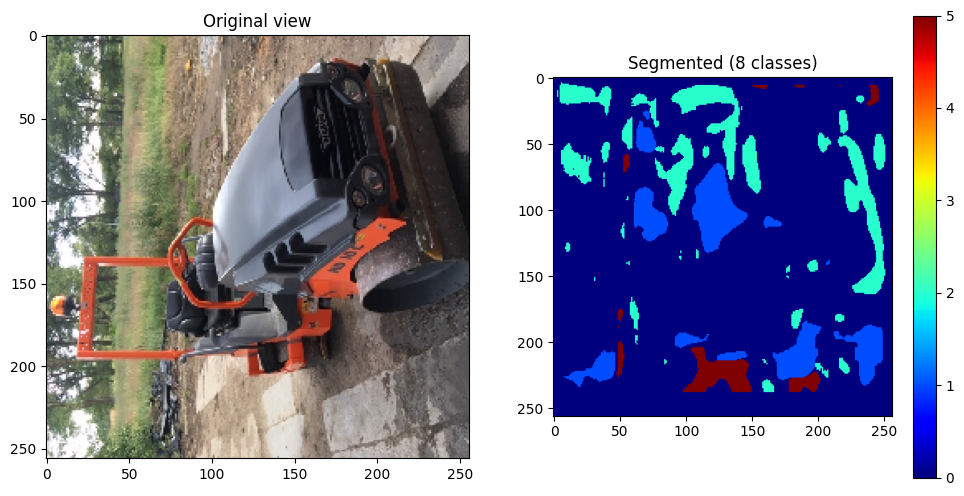

In [7]:
import matplotlib.pyplot as plt

# Results vizualisation
plt.figure(figsize=(12, 6))

# Original view
plt.subplot(1, 2, 1)
plt.title("Original view")
plt.imshow(img)

# Segmented mask
plt.subplot(1, 2, 2)
plt.title("Segmented (8 classes)")
plt.imshow(segmented_mask, cmap='jet')
plt.colorbar()

plt.show()